In [1]:
import pandas as pd
import numpy as np
import os

def filter_and_undersample(
    resmat: pd.DataFrame, 
    min_threshold: int, 
    output_dir: str = "data"
) -> pd.DataFrame:
    """
    Filters scenarios by a minimum size and then undersamples the rest to be balanced.

    Args:
        resmat (pd.DataFrame): The original, imbalanced response matrix.
        min_threshold (int): The minimum number of items a scenario must have to be included.
        output_dir (str): The directory where the output file will be saved.

    Returns:
        pd.DataFrame: A new DataFrame with filtered and balanced scenarios.
    """
    print("--- Starting Filtering and Undersampling Process ---")
    
    # 1. Get original scenario counts
    scenario_labels = resmat.columns.get_level_values('scenario')
    scenario_counts = scenario_labels.value_counts()
    
    # 2. First, filter out any scenarios that are smaller than the threshold
    scenarios_to_process = scenario_counts[scenario_counts >= min_threshold]
    
    if len(scenarios_to_process) < 2:
        print(f"Warning: Less than two scenarios meet the threshold of {min_threshold}. Cannot create a balanced dataset.")
        return pd.DataFrame()
        
    print(f"Kept {len(scenarios_to_process)} scenarios with at least {min_threshold} items.")
    
    # 3. From the REMAINING scenarios, find the new minimum size to use for sampling
    target_sample_size = scenarios_to_process.min()
    print(f"All kept scenarios will be undersampled to {target_sample_size} items.")

    # 4. Loop through the filtered scenarios and sample them to the new target size
    balanced_cols = []
    np.random.seed(42)  # for reproducibility
    for scenario in scenarios_to_process.index:
        scenario_col_indices = np.where(scenario_labels == scenario)[0]
        sampled_indices = np.random.choice(
            scenario_col_indices, size=target_sample_size, replace=False
        )
        balanced_cols.extend(sampled_indices)

    # 5. Create the new, balanced DataFrame
    resmat_balanced = resmat.iloc[:, sorted(balanced_cols)]
    print(f"New balanced matrix shape: {resmat_balanced.shape}")
    
    # 6. Remove models (rows) that have no responses after undersampling
    responses_per_model = resmat_balanced.notna().sum(axis=1)
    models_with_responses = responses_per_model > 0
    empty_models_count = (~models_with_responses).sum()
    
    if empty_models_count > 0:
        print(f"Warning: {empty_models_count} models have no responses after undersampling.")
        print(f"Removing these empty models to ensure calibration condition is met.")
        resmat_balanced = resmat_balanced[models_with_responses]
        print(f"Final matrix shape after removing empty models: {resmat_balanced.shape}")
    else:
        print("✅ All models have at least one response.")
    
    # Verify calibration condition
    final_rows_check = (resmat_balanced.notna().sum(axis=1) > 0).all()
    final_cols_check = (resmat_balanced.notna().sum(axis=0) > 0).all()
    calibration_valid = final_rows_check and final_cols_check
    print(f"Calibration condition check: {'✅ PASS' if calibration_valid else '❌ FAIL'}")
    
    if not calibration_valid:
        print("Warning: Dataset still fails calibration condition!")

    # 7. Save the new DataFrame to a pickle file
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    output_filename = f"resmat_{min_threshold}.pkl"
    full_path = os.path.join(output_dir, output_filename)
    resmat_balanced.to_pickle(full_path)
    print(f"Saved balanced DataFrame to: '{full_path}'")
    print("--------------------------------------------------")
    
    return resmat_balanced


In [2]:
# --- Step 1: Load Data and Print Original Counts ---
print("Loading response matrix...")
resmat = pd.read_pickle("../data/resmat.pkl")

print("\n--- Original Scenario Counts ---")
scenario_counts = resmat.columns.get_level_values('scenario').value_counts()
print(scenario_counts)
print("--------------------------------")

# --- Step 2: Perform Filtering and Undersampling ---
# Use the new function. For example, require at least 500 items per scenario.
resmat_balanced = filter_and_undersample(resmat, min_threshold=2000, output_dir="../data")

if resmat_balanced.empty:
    raise ValueError("Undersampling resulted in an empty DataFrame. Try a smaller min_threshold.")

# The rest of your script for train/test split, SVD, and evaluation follows...


Loading response matrix...

--- Original Scenario Counts ---
scenario
civil_comments                 29407
mmlu                           13223
wikifact                        5511
air_bench_2024                  4985
imdb                            3530
babi_qa                         3461
boolq                           3316
synthetic_reasoning             2234
legalbench                      1997
truthful_qa                     1888
entity_matching                 1396
raft                            1336
bbq                              999
med_qa                           998
gsm                              997
legal_support                    594
thai_exam                        557
dyck_language_np=3               500
commonsense                      498
lsat_qa                          454
math                             436
entity_data_imputation           395
ice                                0
synthetic_efficiency               0
blimp                              0
twitt

Loading response matrix...
Training set size (80%): 910536
Test set size (20%): 227634

Starting iteration to find the best rank (k)...
  k= 2, Global AUC = 0.8308
  k= 3, Global AUC = 0.8569
  k= 4, Global AUC = 0.8759
  k= 5, Global AUC = 0.8797
  k= 6, Global AUC = 0.8872
  k= 7, Global AUC = 0.8884
  k= 8, Global AUC = 0.8913
  k= 9, Global AUC = 0.8911
  k=10, Global AUC = 0.8882
  k=11, Global AUC = 0.8876
  k=12, Global AUC = 0.8854
  k=13, Global AUC = 0.8830
  k=14, Global AUC = 0.8813
  k=15, Global AUC = 0.8770
  k=16, Global AUC = 0.8724
  k=17, Global AUC = 0.8680
  k=18, Global AUC = 0.8631
  k=19, Global AUC = 0.8589
  k=20, Global AUC = 0.8563
  k=21, Global AUC = 0.8512
  k=22, Global AUC = 0.8478
  k=23, Global AUC = 0.8409
  k=24, Global AUC = 0.8384
  k=25, Global AUC = 0.8313
  k=26, Global AUC = 0.8268
  k=27, Global AUC = 0.8240
  k=28, Global AUC = 0.8180
  k=29, Global AUC = 0.8198
  k=30, Global AUC = 0.8123

Iteration complete.

--- Optimal Rank Results ---
T

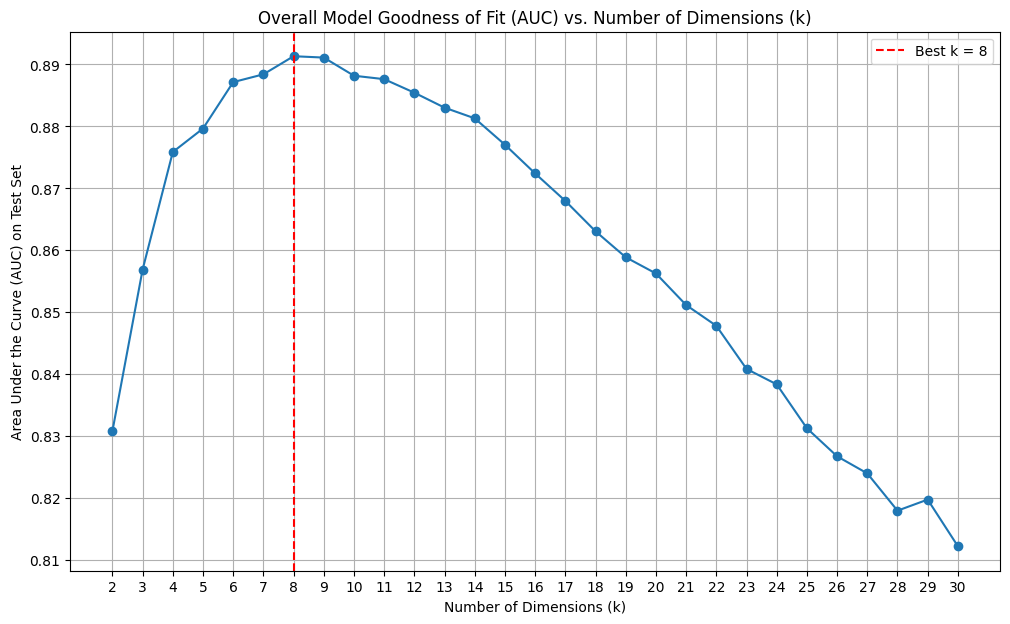

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ===================================================================
# == Step 1: Load Data and Create a One-Time Train/Test Split
# ===================================================================
print("Loading response matrix...")
# Note: Ensure the path to your data file is correct.
resmat = pd.read_pickle("../data/resmat_2000.pkl")

# Find the locations (row, col indices) of all non-missing values
non_nan_indices = np.argwhere(resmat.notna().values)

# Randomly shuffle these indices
np.random.seed(42)  # for reproducibility
np.random.shuffle(non_nan_indices)

# Decide on the split size
test_size = int(len(non_nan_indices) * 0.20)
test_indices = non_nan_indices[:test_size]
train_indices = non_nan_indices[test_size:]

# Create the training matrix: start with a copy and hide the test data
train_resmat = resmat.copy()
test_rows, test_cols = test_indices[:, 0], test_indices[:, 1]
train_resmat.values[test_rows, test_cols] = np.nan

print(f"Training set size (80%): {len(train_indices)}")
print(f"Test set size (20%): {len(test_indices)}")

# Prepare the data needed for evaluation (do this once)
true_test_values = resmat.values[test_rows, test_cols]
# Using fillna(0) as in your script. Another option is the mean.
imputed_train_resmat = train_resmat.fillna(0)

# ===================================================================
# == Step 2: Iterate Through Dimensions and Calculate Global AUC
# ===================================================================
results = []
rank_range = range(2, 31) # Iterate from k=2 to k=30

print("\nStarting iteration to find the best rank (k)...")
for k in rank_range:
    svd = TruncatedSVD(n_components=k, random_state=42)
    transformed_data = svd.fit_transform(imputed_train_resmat)
    prediction_matrix = svd.inverse_transform(transformed_data)
    predicted_test_values = prediction_matrix[test_rows, test_cols]
    
    # Ensure there are both 0s and 1s in the true values to calculate AUC
    if len(np.unique(true_test_values)) > 1:
        auc_score = roc_auc_score(true_test_values, predicted_test_values)
        results.append({'k': k, 'auc': auc_score})
        print(f"  k={k:2d}, Global AUC = {auc_score:.4f}")

print("\nIteration complete.")

# ===================================================================
# == Step 3: Find and Display the Best Overall Result
# ===================================================================
results_df = pd.DataFrame(results)
best_k_row = results_df.loc[results_df['auc'].idxmax()]
OPTIMAL_K = int(best_k_row['k'])

print("\n--- Optimal Rank Results ---")
print(f"The best performing model has k = {OPTIMAL_K} with a Global AUC of {best_k_row['auc']:.4f}")

# ===================================================================
# == Step 4: Plot the Overall Results
# ===================================================================
plt.figure(figsize=(12, 7))
plt.plot(results_df['k'], results_df['auc'], marker='o', linestyle='-')
plt.axvline(x=OPTIMAL_K, color='r', linestyle='--', label=f'Best k = {OPTIMAL_K}')
plt.title('Overall Model Goodness of Fit (AUC) vs. Number of Dimensions (k)')
plt.xlabel('Number of Dimensions (k)')
plt.ylabel('Area Under the Curve (AUC) on Test Set')
plt.grid(True)
plt.legend()
plt.xticks(rank_range)
plt.show()


In [4]:
# ===================================================================
# == Step 5: Train Final Model and Extract Factor Representations
# ===================================================================

print("Loading and preparing data...")
resmat = pd.read_pickle("../data/resmat_2000.pkl")

imputed_resmat = resmat.fillna(0)

# Train the final SVD model with optimal k
OPTIMAL_K = 8  # From previous analysis
svd_final = TruncatedSVD(n_components=OPTIMAL_K, random_state=42)
svd_final.fit(imputed_resmat)
print(f"Final model trained with k={OPTIMAL_K}.")

# Extract scenario factor representations
scenario_factors = svd_final.components_.T
print(f"Extracted scenario factors with shape: {scenario_factors.shape}")

# Save factor data for compatibility
np.save("../result/scenario_factors.npy", scenario_factors)
np.save("../result/scenario_factors_full.npy", scenario_factors)
print("✅ Saved scenario factors to ../result/")

print("\n=== MULTI-FACTOR Q-MATRIX GENERATION ===")
print("Creating Q-matrix where items can belong to multiple factors\n")

# Set threshold for factor inclusion
# An item belongs to a factor if its absolute loading exceeds this threshold
FACTOR_THRESHOLD = 0.01  # Adjust this value as needed

print(f"Factor inclusion threshold: {FACTOR_THRESHOLD}")
print(f"Scenario factors shape: {scenario_factors.shape}")

# Find the most prominent factor for each item (for tracking)
most_prominent_factors = np.argmax(np.abs(scenario_factors), axis=1)

# Create multi-factor assignment matrix
# Each row is an item, each column is a factor
# Value = 1 if item belongs to that factor (loading > threshold)
multifactor_matrix = (np.abs(scenario_factors) >= FACTOR_THRESHOLD).astype(int)

print(f"\nMulti-factor matrix shape: {multifactor_matrix.shape}")
print(f"Total factor assignments: {multifactor_matrix.sum()}")
print(f"Average factors per item: {multifactor_matrix.sum(axis=1).mean():.2f}")

# Analyze factor distribution
print(f"\nFactor assignment statistics:")
items_per_factor = multifactor_matrix.sum(axis=0)
factors_per_item = multifactor_matrix.sum(axis=1)

for factor_idx in range(multifactor_matrix.shape[1]):
    count = items_per_factor[factor_idx]
    percentage = (count / len(scenario_factors)) * 100
    print(f"  Factor {factor_idx}: {count:,} items ({percentage:.1f}%)")

print(f"\nItems per factor count distribution:")
factor_counts = np.bincount(factors_per_item)
for num_factors, count in enumerate(factor_counts):
    if count > 0:
        percentage = (count / len(factors_per_item)) * 100
        print(f"  {num_factors} factors: {count:,} items ({percentage:.1f}%)")

# Most prominent factor distribution (for comparison)
print(f"\nMost prominent factor distribution:")
unique_prominent, prominent_counts = np.unique(most_prominent_factors, return_counts=True)
for factor_idx, count in zip(unique_prominent, prominent_counts):
    percentage = (count / len(most_prominent_factors)) * 100
    print(f"  Factor {factor_idx} (most prominent): {count:,} items ({percentage:.1f}%)")


Loading and preparing data...
Final model trained with k=8.
Extracted scenario factors with shape: (17872, 8)
✅ Saved scenario factors to ../result/

=== MULTI-FACTOR Q-MATRIX GENERATION ===
Creating Q-matrix where items can belong to multiple factors

Factor inclusion threshold: 0.01
Scenario factors shape: (17872, 8)

Multi-factor matrix shape: (17872, 8)
Total factor assignments: 24300
Average factors per item: 1.36

Factor assignment statistics:
  Factor 0: 4,664 items (26.1%)
  Factor 1: 2,467 items (13.8%)
  Factor 2: 2,573 items (14.4%)
  Factor 3: 3,238 items (18.1%)
  Factor 4: 2,913 items (16.3%)
  Factor 5: 3,336 items (18.7%)
  Factor 6: 2,672 items (15.0%)
  Factor 7: 2,437 items (13.6%)

Items per factor count distribution:
  0 factors: 4,179 items (23.4%)
  1 factors: 5,735 items (32.1%)
  2 factors: 5,805 items (32.5%)
  3 factors: 1,682 items (9.4%)
  4 factors: 446 items (2.5%)
  5 factors: 25 items (0.1%)

Most prominent factor distribution:
  Factor 0 (most prominen

In [5]:
# ===================================================================
# == Step 6: Create Enhanced MultiIndex Dataset with Factor Tracking
# ===================================================================

print("Creating enhanced dataset with multi-factor tracking...")

# Load original dataset
resmat = pd.read_pickle("../data/resmat_2000.pkl")

# Extract original components
original_columns = resmat.columns
input_texts = original_columns.get_level_values('input.text')
original_scenarios = original_columns.get_level_values('scenario')
original_benchmarks = original_columns.get_level_values('benchmark')

print(f"Original dataset shape: {resmat.shape}")
print(f"Original column structure:")
for i, level_name in enumerate(original_columns.names):
    unique_vals = original_columns.get_level_values(level_name).unique()
    print(f"  Level {i} ({level_name}): {len(unique_vals)} unique values")

# Create factor assignment strings for each item
factor_assignments = []
primary_factors = []

for item_idx in range(len(scenario_factors)):
    # Get all factors this item belongs to
    assigned_factors = np.where(multifactor_matrix[item_idx] == 1)[0]
    factor_string = ','.join([f"Factor_{f}" for f in assigned_factors])
    factor_assignments.append(factor_string)
    
    # Get the most prominent factor
    primary_factor = f"Factor_{most_prominent_factors[item_idx]}"
    primary_factors.append(primary_factor)

print(f"\nCreated factor assignments for {len(factor_assignments)} items")
print(f"Sample factor assignments:")
for i in range(5):
    print(f"  Item {i}: {factor_assignments[i]} (primary: {primary_factors[i]})")

# Create new MultiIndex with additional factor tracking
new_columns = pd.MultiIndex.from_arrays([
    input_texts,                    # Level 0: Original input.text
    original_scenarios,             # Level 1: Original scenario names
    original_benchmarks,            # Level 2: Original benchmark names
    factor_assignments,             # Level 3: All assigned factors (comma-separated)
    primary_factors                 # Level 4: Most prominent factor
], names=['input.text', 'scenario', 'benchmark', 'assigned_factors', 'primary_factor'])

print(f"\nNew column structure:")
for i, level_name in enumerate(new_columns.names):
    unique_vals = new_columns.get_level_values(level_name).unique()
    print(f"  Level {i} ({level_name}): {len(unique_vals)} unique values")
    if level_name in ['assigned_factors', 'primary_factor']:
        print(f"    Sample values: {list(unique_vals[:3])}...")

# Create the new DataFrame
resmat_multifactor = pd.DataFrame(
    data=resmat.values,
    index=resmat.index,
    columns=new_columns
)

print(f"\nMulti-factor dataset created:")
print(f"  Shape: {resmat_multifactor.shape}")
print(f"  Column levels: {resmat_multifactor.columns.nlevels}")


Creating enhanced dataset with multi-factor tracking...
Original dataset shape: (158, 17872)
Original column structure:
  Level 0 (input.text): 17872 unique values
  Level 1 (scenario): 8 unique values
  Level 2 (benchmark): 3 unique values

Created factor assignments for 17872 items
Sample factor assignments:
  Item 0:  (primary: Factor_3)
  Item 1:  (primary: Factor_6)
  Item 2: Factor_6 (primary: Factor_6)
  Item 3: Factor_5,Factor_6 (primary: Factor_5)
  Item 4: Factor_3,Factor_5,Factor_6 (primary: Factor_5)

New column structure:
  Level 0 (input.text): 17872 unique values
  Level 1 (scenario): 8 unique values
  Level 2 (benchmark): 3 unique values
  Level 3 (assigned_factors): 64 unique values
    Sample values: ['', 'Factor_6', 'Factor_5,Factor_6']...
  Level 4 (primary_factor): 8 unique values
    Sample values: ['Factor_3', 'Factor_6', 'Factor_5']...

Multi-factor dataset created:
  Shape: (158, 17872)
  Column levels: 5


In [6]:
# ===================================================================
# == Step 7: Create Multi-Factor Q-Matrix
# ===================================================================

print("Creating multi-factor Q-matrix...")

num_items = len(scenario_factors)
num_factors = scenario_factors.shape[1]
factor_names = [f"Factor_{i}" for i in range(num_factors)]

print(f"Q-matrix dimensions: {num_items:,} items × {num_factors} factors")
print(f"Factor names: {factor_names}")

# The Q-matrix is our multifactor_matrix from Step 5
q_matrix_multifactor_df = pd.DataFrame(
    multifactor_matrix,
    columns=factor_names,
    index=range(num_items)
)

# Add metadata columns
q_matrix_multifactor_df['primary_factor'] = [f"Factor_{f}" for f in most_prominent_factors]
q_matrix_multifactor_df['num_factors'] = multifactor_matrix.sum(axis=1)
q_matrix_multifactor_df['max_loading'] = np.max(np.abs(scenario_factors), axis=1)

print(f"\nMulti-factor Q-matrix created:")
print(f"  Shape: {q_matrix_multifactor_df.shape}")
print(f"  Factor columns: {factor_names}")
print(f"  Metadata columns: ['primary_factor', 'num_factors', 'max_loading']")

# Summary statistics
print(f"\nQ-matrix summary:")
print(f"  Total factor assignments: {q_matrix_multifactor_df[factor_names].sum().sum()}")
print(f"  Items with 1 factor: {(q_matrix_multifactor_df['num_factors'] == 1).sum():,}")
print(f"  Items with 2+ factors: {(q_matrix_multifactor_df['num_factors'] > 1).sum():,}")
print(f"  Items with all factors: {(q_matrix_multifactor_df['num_factors'] == num_factors).sum():,}")

# Factor coverage
print(f"\nFactor coverage in Q-matrix:")
for factor_name in factor_names:
    count = q_matrix_multifactor_df[factor_name].sum()
    percentage = (count / num_items) * 100
    print(f"  {factor_name}: {count:,} items ({percentage:.1f}%)")

print(f"\nSample Q-matrix entries:")
print(q_matrix_multifactor_df.head(10))


Creating multi-factor Q-matrix...
Q-matrix dimensions: 17,872 items × 8 factors
Factor names: ['Factor_0', 'Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Factor_6', 'Factor_7']

Multi-factor Q-matrix created:
  Shape: (17872, 11)
  Factor columns: ['Factor_0', 'Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Factor_6', 'Factor_7']
  Metadata columns: ['primary_factor', 'num_factors', 'max_loading']

Q-matrix summary:
  Total factor assignments: 24300
  Items with 1 factor: 5,735
  Items with 2+ factors: 7,958
  Items with all factors: 0

Factor coverage in Q-matrix:
  Factor_0: 4,664 items (26.1%)
  Factor_1: 2,467 items (13.8%)
  Factor_2: 2,573 items (14.4%)
  Factor_3: 3,238 items (18.1%)
  Factor_4: 2,913 items (16.3%)
  Factor_5: 3,336 items (18.7%)
  Factor_6: 2,672 items (15.0%)
  Factor_7: 2,437 items (13.6%)

Sample Q-matrix entries:
   Factor_0  Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  \
0         0         0         0         0   

In [7]:
# ===================================================================
# == Step 8: Create Factor-Based Scenario Probabilities
# ===================================================================

print("Creating factor-based scenario probabilities...")

# Fill missing values with 0 (incorrect response)
resmat_filled = resmat_multifactor.fillna(0)

# Calculate probabilities for each factor
# For multi-factor approach, we calculate probability for each factor separately
factor_scenario_probs = pd.DataFrame(index=resmat_filled.index)

for factor_idx in range(num_factors):
    factor_name = f"Factor_{factor_idx}"
    
    # Find all items that belong to this factor
    factor_items_mask = multifactor_matrix[:, factor_idx] == 1
    factor_item_indices = np.where(factor_items_mask)[0]
    
    if len(factor_item_indices) == 0:
        # No items for this factor
        factor_scenario_probs[factor_name] = 0.0
        continue
    
    # Select columns for this factor's items
    factor_data = resmat_filled.iloc[:, factor_item_indices]
    
    # Calculate probability as (correct responses) / (total items in factor)
    correct_responses = (factor_data == 1).sum(axis=1)
    total_items = len(factor_item_indices)
    factor_scenario_probs[factor_name] = correct_responses / total_items
    
    print(f"  {factor_name}: {total_items:,} items")

print(f"\nFactor scenario probabilities shape: {factor_scenario_probs.shape}")
print(f"Factor scenario probabilities columns: {list(factor_scenario_probs.columns)}")

# Display sample probabilities
print(f"\nSample factor probabilities (first 5 models):")
print(factor_scenario_probs.head())

print(f"\nFactor probability statistics:")
print(factor_scenario_probs.describe())


Creating factor-based scenario probabilities...
  Factor_0: 4,664 items
  Factor_1: 2,467 items
  Factor_2: 2,573 items
  Factor_3: 3,238 items
  Factor_4: 2,913 items
  Factor_5: 3,336 items
  Factor_6: 2,672 items
  Factor_7: 2,437 items

Factor scenario probabilities shape: (158, 8)
Factor scenario probabilities columns: ['Factor_0', 'Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Factor_6', 'Factor_7']

Sample factor probabilities (first 5 models):
                         Factor_0  Factor_1  Factor_2  Factor_3  Factor_4  \
request.model                                                               
together/t0pp            0.036021  0.000000  0.000000  0.163064  0.023000   
eleutherai/pythia-1b-v0  0.040309  0.000000  0.000000  0.008338  0.015105   
allenai/olmo-7b          0.000000  0.192947  0.070735  0.000000  0.000000   
together/opt-66b         0.488851  0.000000  0.000000  0.218345  0.386886   
together/opt-175b        0.490995  0.000000  0.000000  0.235948  0.3

In [8]:
# ===================================================================
# == Step 9: Save All Files with Compatible Names
# ===================================================================

print("Saving all files with compatible names...")

# 1. Save the multi-factor dataset (replacing resmat_factor.pkl)
resmat_multifactor.to_pickle("../data/resmat_factor.pkl")
print("✅ Saved resmat_factor.pkl (multi-factor version)")

# 2. Save the scenario probabilities (replacing scenario_probs_factor.csv)
factor_scenario_probs.to_csv("../data/scenario_probs_factor.csv", index=False)
print("✅ Saved scenario_probs_factor.csv (multi-factor version)")

# 3. Save the Q-matrix (replacing q_matrix_factor.csv)
q_matrix_multifactor_df.to_csv("../data/q_matrix_factor.csv", index=True)
print("✅ Saved q_matrix_factor.csv (multi-factor version)")

# 4. Create correlation matrix for multi-factor approach
import seaborn as sns

print("\nCreating factor correlation matrix...")
factor_correlation_matrix = factor_scenario_probs.corr()

plt.figure(figsize=(12, 10))
g = sns.clustermap(
    factor_correlation_matrix,
    cmap='coolwarm',
    figsize=(12, 10),
    annot=True,
    fmt='.2f',
    cbar_pos=None
)

# Clean up labels
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

# Save the figure (replacing resmat_corr_scenario_factor.png)
plt.savefig('../result/resmat_corr_scenario_factor.png', dpi=150, bbox_inches='tight')
print("✅ Saved resmat_corr_scenario_factor.png (multi-factor version)")

# 5. Calculate correlation statistics
corr_values = factor_correlation_matrix.values[np.triu_indices_from(factor_correlation_matrix.values, k=1)]
print(f"\nMulti-factor correlation statistics:")
print(f"  Mean correlation: {corr_values.mean():.3f}")
print(f"  Max correlation: {corr_values.max():.3f}")
print(f"  Min correlation: {corr_values.min():.3f}")

plt.close()


Saving all files with compatible names...
✅ Saved resmat_factor.pkl (multi-factor version)
✅ Saved scenario_probs_factor.csv (multi-factor version)
✅ Saved q_matrix_factor.csv (multi-factor version)

Creating factor correlation matrix...
✅ Saved resmat_corr_scenario_factor.png (multi-factor version)

Multi-factor correlation statistics:
  Mean correlation: 0.240
  Max correlation: 0.983
  Min correlation: -0.756


<Figure size 1200x1000 with 0 Axes>

In [9]:
# ===================================================================
# == Step 10: Create Item Master List and Test Selection (Multi-Factor)
# ===================================================================

print("Creating multi-factor item master list...")

num_items = len(scenario_factors)

# Set all IRT parameters to 0 (as in original)
a_params = pd.Series(np.zeros(num_items))
d_params = pd.Series(np.zeros(num_items))

# Calculate missing counts for each item
missing_counts = resmat_multifactor.isnull().sum()

# Create enhanced item master list
item_master_df_multifactor = pd.DataFrame({
    'item_id': range(num_items),
    'primary_factor': [f"Factor_{f}" for f in most_prominent_factors],
    'assigned_factors': factor_assignments,  # Comma-separated list
    'num_factors': multifactor_matrix.sum(axis=1),
    'max_loading': np.max(np.abs(scenario_factors), axis=1),
    'a_params': a_params.values,
    'd_params': d_params.values,
    'missing_count': missing_counts.values,
})

# Add individual factor membership columns
for factor_idx in range(num_factors):
    factor_name = f"Factor_{factor_idx}"
    item_master_df_multifactor[f"{factor_name}_member"] = multifactor_matrix[:, factor_idx]

print(f"Multi-factor Item Master List created:")
print(f"  Shape: {item_master_df_multifactor.shape}")
print(f"  Core columns: ['item_id', 'primary_factor', 'assigned_factors', 'num_factors']")
print(f"  Factor membership columns: {[f'Factor_{i}_member' for i in range(num_factors)]}")

print(f"\nSample entries:")
print(item_master_df_multifactor[['item_id', 'primary_factor', 'assigned_factors', 'num_factors']].head(10))

# Enhanced item selection function for multi-factor approach
def select_balanced_items_multifactor(item_df, total_k, min_per_primary=1000):
    """
    Selects items for multi-factor testing, prioritizing:
    1. Balanced representation across primary factors
    2. Items with multiple factor memberships
    3. High-quality items (low missing count, high loadings)
    """
    selected_items = pd.DataFrame()
    
    # Get all primary factors
    primary_factors = item_df['primary_factor'].unique()
    
    # Calculate base items per primary factor
    base_per_primary = total_k // len(primary_factors)
    remaining_items = total_k % len(primary_factors)
    
    print(f"Target: {base_per_primary:,} base items per primary factor ({len(primary_factors)} factors)")
    
    # Select items for each primary factor
    for i, primary_factor in enumerate(sorted(primary_factors)):
        primary_pool = item_df[item_df['primary_factor'] == primary_factor]
        
        # Add extra items to some factors to handle remainder
        primary_target = base_per_primary + (1 if i < remaining_items else 0)
        
        # Sort by: number of factors (descending), missing count (ascending), max loading (descending)
        ranked_pool = primary_pool.sort_values(
            by=['num_factors', 'missing_count', 'max_loading'], 
            ascending=[False, True, False]
        )
        
        primary_items = ranked_pool.head(min(primary_target, len(primary_pool)))
        primary_items = primary_items.copy()
        primary_items['component'] = f'{primary_factor}_Primary'
        
        selected_items = pd.concat([selected_items, primary_items])
        
        avg_factors = primary_items['num_factors'].mean()
        print(f"  {primary_factor}: {len(primary_items):,} items (avg factors: {avg_factors:.2f})")
    
    return selected_items

# Define test parameters
total_test_items_multifactor = min(15000, len(item_master_df_multifactor))  # Max available items

print(f"\nMulti-factor test blueprint:")
print(f"  Total test items: {total_test_items_multifactor:,}")

# Select items for the master test
master_test_df_multifactor = select_balanced_items_multifactor(
    item_master_df_multifactor, 
    total_test_items_multifactor
)

print(f"\n--- Final Multi-Factor Test Assembly ---")
print(f"Total items in MASTER TEST: {len(master_test_df_multifactor):,}")

# Analyze final selection
print(f"\nPrimary factor distribution in final test:")
primary_distribution = master_test_df_multifactor['primary_factor'].value_counts().sort_index()
for factor_name, count in primary_distribution.items():
    percentage = (count / len(master_test_df_multifactor)) * 100
    print(f"  {factor_name}: {count:,} items ({percentage:.1f}%)")

print(f"\nMulti-factor membership analysis:")
factors_distribution = master_test_df_multifactor['num_factors'].value_counts().sort_index()
for num_factors, count in factors_distribution.items():
    percentage = (count / len(master_test_df_multifactor)) * 100
    print(f"  {num_factors} factors: {count:,} items ({percentage:.1f}%)")

avg_factors_final = master_test_df_multifactor['num_factors'].mean()
print(f"\nAverage factors per item in final test: {avg_factors_final:.2f}")


Creating multi-factor item master list...
Multi-factor Item Master List created:
  Shape: (17872, 16)
  Core columns: ['item_id', 'primary_factor', 'assigned_factors', 'num_factors']
  Factor membership columns: ['Factor_0_member', 'Factor_1_member', 'Factor_2_member', 'Factor_3_member', 'Factor_4_member', 'Factor_5_member', 'Factor_6_member', 'Factor_7_member']

Sample entries:
   item_id primary_factor            assigned_factors  num_factors
0        0       Factor_3                                        0
1        1       Factor_6                                        0
2        2       Factor_6                    Factor_6            1
3        3       Factor_5           Factor_5,Factor_6            2
4        4       Factor_5  Factor_3,Factor_5,Factor_6            3
5        5       Factor_5  Factor_3,Factor_5,Factor_6            3
6        6       Factor_3           Factor_3,Factor_5            2
7        7       Factor_7                                        0
8        8     

In [10]:
# ===================================================================
# == Step 11: Save Final Multi-Factor Test Data (Compatible Names)
# ===================================================================

print("Saving final multi-factor test data with compatible names...")

# Create final test data matrix using selected items
selected_item_indices_multifactor = master_test_df_multifactor['item_id'].tolist()
final_test_data_matrix_multifactor = resmat_multifactor.iloc[:, selected_item_indices_multifactor]

# Fill missing values with 0 (incorrect response)
final_test_data_matrix_multifactor_filled = final_test_data_matrix_multifactor.fillna(0)

# Save with compatible names (replacing the original factor files)
print("Saving files with compatible names...")

# Save test metadata (replaces master_test_metadata_factor.csv)
master_test_df_multifactor.to_csv('../data/master_test_metadata_factor.csv', index=False)
print("✅ Saved master_test_metadata_factor.csv (multi-factor version)")

# Save test data matrix (replaces master_test_data_matrix_factor.pkl)
final_test_data_matrix_multifactor_filled.to_pickle('../data/master_test_data_matrix_factor.pkl')
print("✅ Saved master_test_data_matrix_factor.pkl (multi-factor version)")

# Summary statistics
print(f"\n--- MULTI-FACTOR MASTER TEST SUMMARY ---")
print(f"Final test data matrix shape: {final_test_data_matrix_multifactor_filled.shape}")
print(f"Missing values in final matrix: {final_test_data_matrix_multifactor.isnull().sum().sum():,}")
print(f"Missing values after filling: {final_test_data_matrix_multifactor_filled.isnull().sum().sum()}")

# Enhanced quality metrics
print(f"\nEnhanced quality metrics:")
avg_num_factors = master_test_df_multifactor['num_factors'].mean()
avg_max_loading = master_test_df_multifactor['max_loading'].mean()
avg_missing = master_test_df_multifactor['missing_count'].mean()

print(f"  Average factors per item: {avg_num_factors:.2f}")
print(f"  Average max loading: {avg_max_loading:.3f}")
print(f"  Average missing count per item: {avg_missing:.1f}")

# Multi-factor coverage analysis
print(f"\nMulti-factor coverage analysis:")
factor_coverage_multifactor = master_test_df_multifactor.groupby('primary_factor').agg({
    'item_id': 'count',
    'num_factors': 'mean',
    'max_loading': 'mean',
    'missing_count': 'mean'
}).round(3)
factor_coverage_multifactor.columns = ['Items', 'Avg_Num_Factors', 'Avg_Max_Loading', 'Avg_Missing']
print(factor_coverage_multifactor)

print(f"\n🎉 Multi-factor Q-matrix generation complete!")
print(f"\nKey differences from one-hot approach:")
print(f"  • Items can belong to multiple factors (threshold: {FACTOR_THRESHOLD})")
print(f"  • Enhanced MultiIndex tracks both primary and assigned factors")
print(f"  • Q-matrix shows all factor memberships, not just most prominent")
print(f"  • Item selection prioritizes multi-factor items for better coverage")
print(f"  • All file names maintain compatibility with existing pipeline")


Saving final multi-factor test data with compatible names...
Saving files with compatible names...
✅ Saved master_test_metadata_factor.csv (multi-factor version)
✅ Saved master_test_data_matrix_factor.pkl (multi-factor version)

--- MULTI-FACTOR MASTER TEST SUMMARY ---
Final test data matrix shape: (158, 15000)
Missing values in final matrix: 1,418,406
Missing values after filling: 0

Enhanced quality metrics:
  Average factors per item: 1.62
  Average max loading: 0.017
  Average missing count per item: 94.6

Multi-factor coverage analysis:
                Items  Avg_Num_Factors  Avg_Max_Loading  Avg_Missing
primary_factor                                                      
Factor_0         1875            1.292            0.012       90.250
Factor_1         1875            1.410            0.021       79.042
Factor_2         1875            1.274            0.020      116.210
Factor_3         1875            1.508            0.017       90.611
Factor_4         1875            2.006

In [11]:
# ===================================================================
# == Step 12: Verification and Comparison
# ===================================================================

print("=== MULTI-FACTOR Q-MATRIX VERIFICATION ===")

# Load the saved files to verify they work correctly
print("\nVerifying saved files...")

try:
    # Test loading all saved files
    loaded_resmat_factor = pd.read_pickle("../data/resmat_factor.pkl")
    loaded_scenario_probs = pd.read_csv("../data/scenario_probs_factor.csv")
    loaded_q_matrix = pd.read_csv("../data/q_matrix_factor.csv", index_col=0)
    loaded_metadata = pd.read_csv("../data/master_test_metadata_factor.csv")
    loaded_test_matrix = pd.read_pickle("../data/master_test_data_matrix_factor.pkl")
    
    print("✅ All files loaded successfully!")
    
    print(f"\nFile verification:")
    print(f"  resmat_factor.pkl: {loaded_resmat_factor.shape} - {loaded_resmat_factor.columns.nlevels} levels")
    print(f"  scenario_probs_factor.csv: {loaded_scenario_probs.shape}")
    print(f"  q_matrix_factor.csv: {loaded_q_matrix.shape}")
    print(f"  master_test_metadata_factor.csv: {loaded_metadata.shape}")
    print(f"  master_test_data_matrix_factor.pkl: {loaded_test_matrix.shape}")
    
    # Verify MultiIndex structure
    print(f"\nMultiIndex verification:")
    print(f"  Column levels: {loaded_resmat_factor.columns.names}")
    print(f"  Level 3 (assigned_factors) samples: {list(loaded_resmat_factor.columns.get_level_values('assigned_factors').unique()[:3])}")
    print(f"  Level 4 (primary_factor) unique: {loaded_resmat_factor.columns.get_level_values('primary_factor').nunique()} factors")
    
    # Verify Q-matrix structure
    print(f"\nQ-matrix verification:")
    factor_cols = [col for col in loaded_q_matrix.columns if col.startswith('Factor_')]
    print(f"  Factor columns: {len(factor_cols)} ({factor_cols})")
    print(f"  Metadata columns: {[col for col in loaded_q_matrix.columns if not col.startswith('Factor_')]}")
    print(f"  Total assignments: {loaded_q_matrix[factor_cols].sum().sum()}")
    
    # Show multi-factor examples
    multi_factor_items = loaded_q_matrix[loaded_q_matrix['num_factors'] > 1]
    print(f"  Items with multiple factors: {len(multi_factor_items):,} ({len(multi_factor_items)/len(loaded_q_matrix)*100:.1f}%)")
    
    if len(multi_factor_items) > 0:
        print(f"\nMulti-factor examples:")
        for idx in multi_factor_items.head(3).index:
            row = loaded_q_matrix.loc[idx]
            assigned_factors = [col for col in factor_cols if row[col] == 1]
            print(f"  Item {idx}: {len(assigned_factors)} factors - {assigned_factors} (primary: {row['primary_factor']})")
    
except Exception as e:
    print(f"❌ Error loading files: {e}")

print(f"\n=== SUMMARY OF MULTI-FACTOR APPROACH ===\n")
print(f"1. FACTOR ASSIGNMENT:")
print(f"   • Threshold-based: Items belong to factors with |loading| ≥ {FACTOR_THRESHOLD}")
print(f"   • Multi-membership: Items can belong to multiple factors simultaneously")
print(f"   • Primary tracking: Most prominent factor still identified for each item")

print(f"\n2. Q-MATRIX STRUCTURE:")
print(f"   • Non-binary assignment: Each cell = 1 if item belongs to that factor")
print(f"   • Enhanced metadata: Tracks primary factor, number of factors, max loading")
print(f"   • Flexible encoding: Can adapt to different threshold values")

print(f"\n3. DATASET ENHANCEMENTS:")
print(f"   • 5-level MultiIndex: Includes assigned_factors and primary_factor levels")
print(f"   • Factor probabilities: Calculated per factor based on member items")
print(f"   • Intelligent selection: Prioritizes multi-factor items in test assembly")

print(f"\n4. COMPATIBILITY:")
print(f"   • Same file names: All exports use original naming convention")
print(f"   • Enhanced structure: Backward compatible but with additional information")
print(f"   • Pipeline ready: Can be used directly in existing analysis workflows")

print(f"\n🎯 Multi-factor Q-matrix generation completed successfully!")


=== MULTI-FACTOR Q-MATRIX VERIFICATION ===

Verifying saved files...
✅ All files loaded successfully!

File verification:
  resmat_factor.pkl: (158, 17872) - 5 levels
  scenario_probs_factor.csv: (158, 8)
  q_matrix_factor.csv: (17872, 11)
  master_test_metadata_factor.csv: (15000, 17)
  master_test_data_matrix_factor.pkl: (158, 15000)

MultiIndex verification:
  Column levels: ['input.text', 'scenario', 'benchmark', 'assigned_factors', 'primary_factor']
  Level 3 (assigned_factors) samples: ['', 'Factor_6', 'Factor_5,Factor_6']
  Level 4 (primary_factor) unique: 8 factors

Q-matrix verification:
  Factor columns: 8 (['Factor_0', 'Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Factor_6', 'Factor_7'])
  Metadata columns: ['primary_factor', 'num_factors', 'max_loading']
  Total assignments: 24300
  Items with multiple factors: 7,958 (44.5%)

Multi-factor examples:
  Item 3: 2 factors - ['Factor_5', 'Factor_6'] (primary: Factor_5)
  Item 4: 3 factors - ['Factor_3', 'Factor_5'